## Reading generated images

In [11]:
import cv2
import json
import time
import requests
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40
from IPython.display import clear_output
#BASE_URL = "http://localhost:8000/"
BASE_URL = "https://dgmd-s17-assets.s3.amazonaws.com/train/generated-text-images/"

def setup_plt(keep_ticks=False):
    plt.clf()
    plt.close()
    ax = plt.gca()
    if keep_ticks == False:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])

In [2]:
with open('merged.json', 'r') as rf:
    data = json.load(rf)

prompts = data["prompts"]
sources = data["images"]

In [ ]:
DELAY_READ = 0.001
#NUM_READ = 10000
NUM_READ = 100

images = []
print('LOADING IMAGES...')
src_subset = sources[:NUM_READ]
for src in src_subset:
    image_url = BASE_URL + src["file_name"]
    resp = requests.get(image_url, stream=True).raw
    arr = np.asarray(bytearray(resp.read()), dtype="uint8")
    decoded = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if decoded is None:
        print('Unable to load', image_url)
        continue
    img = decoded[:,:,::-1]
    images.append((src,img))
    time.sleep(DELAY_READ)
    if len(images) % 10 == 0:
        print(round(100*len(images)/len(src_subset)),'%')
print('LOADED', len(images), 'IMAGES!')

LOADING IMAGES...
10 %
20 %
30 %


## OCR

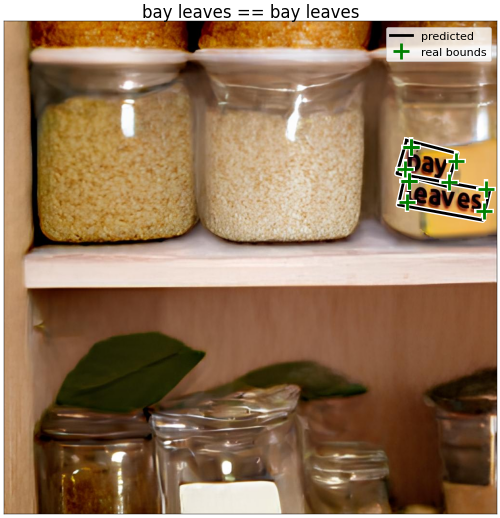

60 %
70 %
80 %
90 %
100 %
DONE


In [4]:
import easyocr

N_VIZ = 5
DELAY_VIZ = 1.5
print('LOADING MODEL...')
reader = easyocr.Reader(['en'])
def result_to_box(result):
    for r in result:
        yield np.round(r[0]).astype(int).tolist()
def result_to_words(result):
    # TODO -- fix source dataset
    ok_err = {
        'llspice': 'allspice'
    }
    for r in result:
        yield ok_err.get(r[1],r[1])
def src_to_words(src):
    meta_words = src["words"]
    for lines in meta_words:
        for word in lines["word"].split('\n'):
            yield word
def src_to_box(src):
    meta_words = src["words"]
    for box in meta_words:
        vecs = []
        for point in box["points"]:
            vecs.append([point["x"], point["y"]])
        yield vecs

real_values = []
result_values = []
for (i, (src,img)) in enumerate(images):
    real_box = list(src_to_box(src))
    real_words = list(src_to_words(src))
    real_text = ' '.join(real_words)
    real_values.append({
        "text": real_text,
        "bounds": real_box,
        "image": img
    })
    result = reader.readtext(img)
    result_box = list(result_to_box(result))
    result_words = list(result_to_words(result))
    result_text = ' '.join(result_words)
    result_values.append({
        "text": result_text,
        "bounds": result_box,
    })
    if len(images) % 10 == 0:
        print(round(100*len(real_values)/len(images)),'%')
    if (i >= N_VIZ):
        continue
    time.sleep(DELAY_VIZ)
    setup_plt()
    clear_output(wait=True)
    plt.imshow(img)

    # Calculate title
    correct = result_text == real_text
    sep = "==" if correct else "≠"
    plt.title(f'{result_text} {sep} {real_text}', fontsize = 30)

    # Draw predicted bounding boxes
    for (res_i, res_box) in enumerate(result_box):
        c = 'k'
        xs, ys = zip(*res_box)
        xs += (xs[0],)
        ys += (ys[0],)            
        l = 'predicted' if res_i == 0 else f'_res_{res_i}'
        plt.plot(xs,ys, 'w', label='_res_bg', linewidth=10)
        plt.plot(xs,ys, 'k', label=l, linewidth=5)
    
    # Draw real bounding boxes
    for (rea_i, rea_box) in enumerate(real_box):
        xs, ys = zip(*rea_box)
        xs += (xs[0],)
        ys += (ys[0],)    
        l = 'real bounds' if rea_i == 0 else f'_rea_{rea_i}'
        plt.plot(xs,ys, 'w+', label='_real_bg', mew=8, ms=35)
        plt.plot(xs,ys, 'g+', label=l, mew=5, ms=30)
        
    plt.legend(fontsize = 20)
    plt.show()
print('DONE')

# Evaluation

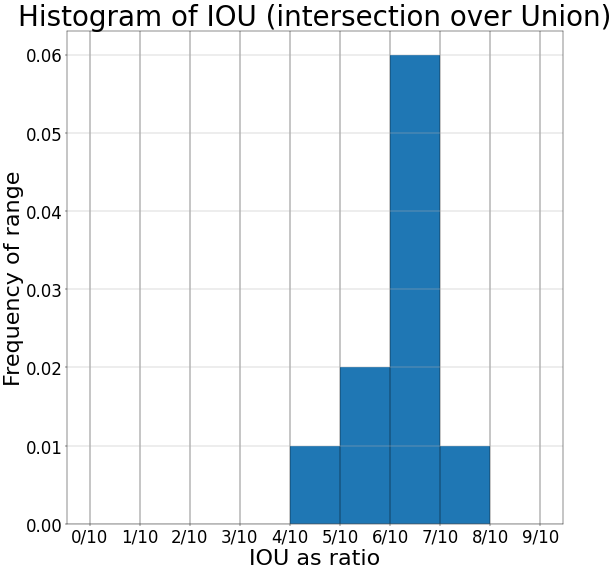

In [33]:
N_EVAL = 5

ious = []

for (rea, res) in zip(real_values, result_values):
    rea_canvas = np.zeros(rea["image"].shape[:2], dtype=np.float32)
    res_canvas = np.zeros(rea["image"].shape[:2], dtype=np.float32)
#    time.sleep(DELAY_VIZ) # TODO
#    setup_plt() # TODO
#    clear_output(wait=True) # TODO
    # Render the real bounds
    for box in rea["bounds"]:
        cv2.fillPoly(rea_canvas, pts =[np.array(box)], color =(1))
    # Render the result bounds
    for box in res["bounds"]:
        cv2.fillPoly(res_canvas, pts =[np.array(box)], color =(1))

    # Calculate the union
    union = np.logical_or(rea_canvas > 0, res_canvas > 0)
    intersection = np.logical_and(rea_canvas > 0, res_canvas > 0)
    iou = round(100 * (intersection.sum() / union.sum()))
#    plt.imshow(intersection)
    ious.append(iou)

setup_plt(True)
bin_range = list(range(0,100,10))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(ious, bins = bin_range, density = True)
plt.title(f'Histogram of IOU (intersection over Union)', fontsize = 50)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x//10}/10' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("IOU as ratio", fontsize=40)
plt.ylabel("Frequency of range", fontsize=40)
plt.show() # TODO
    